# Notes

The error scales like 
$$KL(p_0||\tilde{q}_T) \sim L(h,\sigma_0, \mathscr{E}) \epsilon^2 + \mathcal{O}(\epsilon^3)$$
where 
- $\mathscr{E} = \mathcal{O}(1)$ determines the error type for score functions; the true error in score in the paper equals to $\mathscr{E}_t(x) S_t(x)$ herein, where $S_t(x)$ is the exact score function.
- $\sigma_0$ determines the data distribution, as we consider $p_0 = N(0, \sigma_0^2)$.

## Part 0: Utility functions

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn import datasets, linear_model
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
import pandas as pd
import math

def integrate(vec, N, dt):
    # use trapezoidal rule
    return torch.cumsum(torch.concat((torch.zeros(1), (vec[0:(N-1)] + vec[1:N])/2*dt),dim=0),dim=0)

def kl(σ1, σ2):
    # kl divergence between two univariate gaussians with mean zero.
    return torch.log(σ2/σ1) + (σ1**2)/(2*σ2**2) - 1/2

def error(αscale, h_vec_sq, σt_vec, Nt, dt, σ0):
    # σt_vec = σt(T - t_vec)
    alpha_vec = αscale * (-1/σt_vec**2)
    beta_vec = 1/2 + (1 + h_vec_sq)/2*(-1/σt_vec**2 + alpha_vec)
    gt = integrate(beta_vec, Nt+1, dt)
    σsqapprox = torch.exp(2*gt[-1])*(σt_vec[0]**2).item() +\
        (integrate(torch.exp(-2*(gt - gt[-1])) * (h_vec_sq), Nt+1, dt))[-1]
    
    return kl(σ0, torch.sqrt(σsqapprox))

In [2]:
# fixed parameters
T = 2
Nt = 2*10**6
dt = T/Nt
t_vec = torch.arange(0, T+1.0e-10, step=dt)

linestyle = ['solid','dashed','dotted','dashdot']

### You can turn off saving figures by letting save_fig = False

In [3]:
# savefig?
save_fig = True
# save_fig = False

import os

if save_fig:
    if not os.path.exists("PDF"):
        os.mkdir("PDF"); 
    if not os.path.exists("EPS"):
        os.mkdir("EPS");
    if not os.path.exists("../assets"):
        os.mkdir("../assets");

## Part 1: when $\epsilon=0$, test the validity of the codes

In [4]:
h_max = np.sqrt(20)
h_N = 50
h_value = torch.arange(0, h_max, h_max/h_N)

ϵ = 0.00
γ1 = 0.95
γ2 = 0.99
αscale_cases = [0] # the error term
σ0_cases = [0.2, 0.4, 0.6, 0.8, 1.5, 2.0, 3.0]

for i in tqdm(range(len(σ0_cases))):
    for k in range(len(αscale_cases)):
        σ0 = σ0_cases[i]
        αscale = αscale_cases[k]
        σt_vec = torch.sqrt(σ0**2*torch.exp(-(T-t_vec)) + 1 - torch.exp(-(T - t_vec)))

        error_value = torch.zeros(h_N)
        for j in range(h_N):
            # we use a constant function h herein
            error_value[j] = error(αscale, torch.ones(Nt+1)*(h_value[j]**2), σt_vec, Nt, dt, σ0)
        
        print("KL={:.2E}".format(torch.max(error_value).item()))

 14%|██████▍                                      | 1/7 [00:00<00:03,  1.64it/s]

KL=0.00E+00


 29%|████████████▊                                | 2/7 [00:00<00:02,  2.11it/s]

KL=0.00E+00


 43%|███████████████████▎                         | 3/7 [00:01<00:01,  2.19it/s]

KL=5.96E-08


 57%|█████████████████████████▋                   | 4/7 [00:01<00:01,  2.17it/s]

KL=0.00E+00


 71%|████████████████████████████████▏            | 5/7 [00:02<00:00,  2.18it/s]

KL=0.00E+00


 86%|██████████████████████████████████████▌      | 6/7 [00:02<00:00,  2.16it/s]

KL=0.00E+00


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.16it/s]

KL=0.00E+00


### Conclusion: error in KL = 0 when $\epsilon = 0$

## Part 2: when $\epsilon$ is fixed, error as a function of $h$ 

  0%|                                                     | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_188/183737071.py:32: RuntimeWarning: divide by zero encountered in log10
  ax.plot(x[x_idx], np.log10(y[x_idx]))
/tmp/ipykernel_188/183737071.py:32: RuntimeWarning: invalid value encountered in log10
  ax.plot(x[x_idx], np.log10(y[x_idx]))
 57%|█████████████████████████▋                   | 4/7 [00:08<00:06,  2.09s/it]/tmp/ipykernel_188/183737071.py:27: RuntimeWarning: divide by zero encountered in log10
  ax.plot(h_value.numpy()**2, np.log10(error_value.numpy()))
/tmp/ipykernel_188/183737071.py:27: RuntimeWarning: invalid value encountered in log10
  ax.plot(h_value.numpy()**2, np.log10(error_value.numpy()))
100%|█████████████████████████████████████████████| 7/7 [00:15<00:00,  2.20s/it]


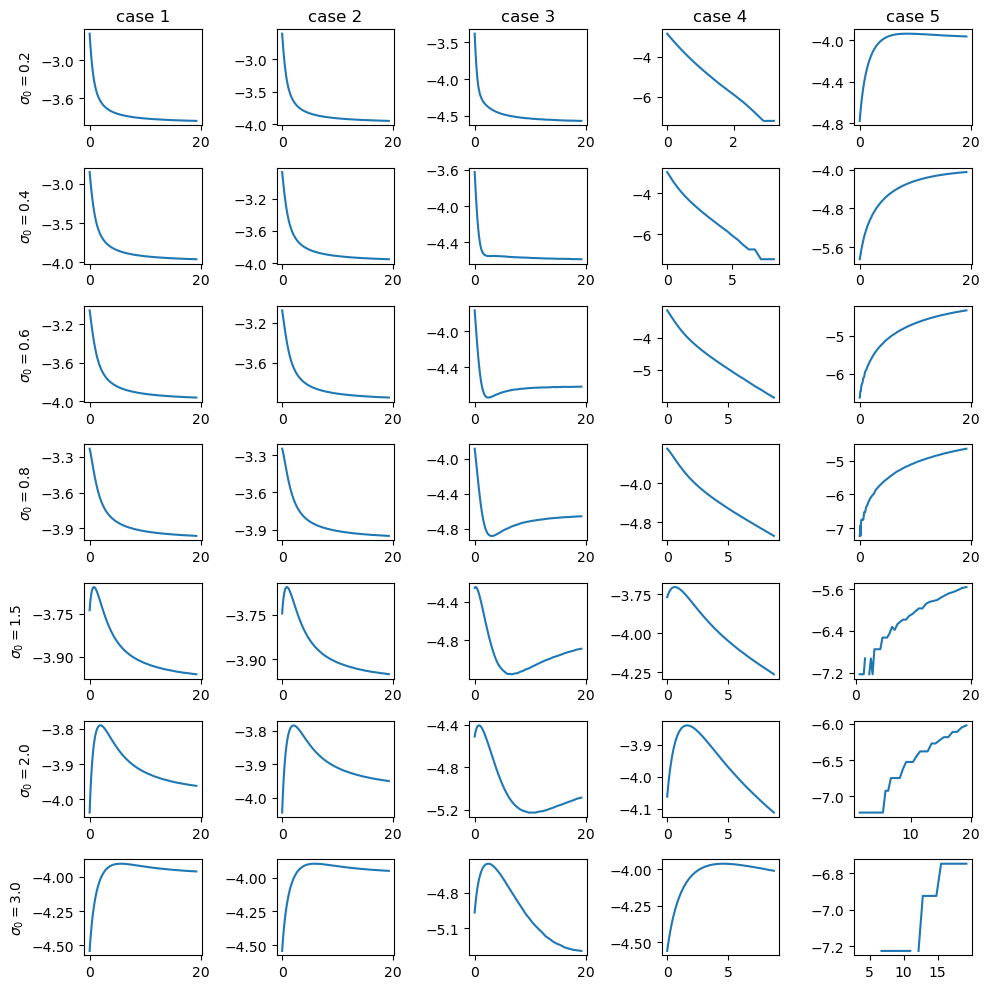

In [5]:
h_max = np.sqrt(20)
h_N = 50
h_value = torch.arange(0, h_max, h_max/h_N)

ϵ = 0.02
γ1 = 0.95
γ2 = 0.99
αscale_cases = [ϵ, -ϵ, ϵ/2*(1+torch.sin(2*np.pi*t_vec/T)), ϵ*(t_vec<γ1*T), ϵ*(t_vec>γ2*T)]
σ0_cases = [0.2, 0.4, 0.6, 0.8, 1.5, 2.0, 3.0]

fig = plt.figure(figsize=(10,10))
for i in tqdm(range(len(σ0_cases))):
    for k in range(len(αscale_cases)):
        σ0 = σ0_cases[i]
        αscale = αscale_cases[k]
        σt_vec = torch.sqrt(σ0**2*torch.exp(-(T-t_vec)) + 1 - torch.exp(-(T - t_vec)))

        error_value = torch.zeros(h_N)
        for j in range(h_N):
            # we use a constant function h herein
            error_value[j] = error(αscale, torch.ones(Nt+1)*(h_value[j]**2), σt_vec, Nt, dt, σ0)
        
        ax = plt.subplot(len(σ0_cases),len(αscale_cases),i*len(αscale_cases)+k+1)
        ax.yaxis.set_major_locator(MaxNLocator(3)) 

        if k != 3:
            ax.plot(h_value.numpy()**2, np.log10(error_value.numpy()))
        else:
            x = h_value.numpy()**2
            x_idx = x <= 9.0
            y = error_value.numpy()
            ax.plot(x[x_idx], np.log10(y[x_idx]))

        if k == 0:
            ax.set_ylabel(r"$\sigma_0 = {0}$".format(σ0))
        if i == 0:
            ax.set_title(r"case {0}".format(k+1))
            
#         s = "{:d}{:d}".format(i,k)
#         plt.title(s)
plt.tight_layout()
if save_fig:
    plt.savefig("EPS/error_wrt_const_h.eps")
    plt.savefig("PDF/error_wrt_const_h.pdf")
    plt.savefig("../assets/error_wrt_const_h.eps")

## Part 3: Estimate the leading order

In [6]:
def compute_LeadingOrder(σ0, error_type, save_fig=False, \
                         plot_fig=True, title="", h_max = 10.0, est_num = 3, h_N = 50, save_fig_type=[1]):
    
    σt_vec = torch.sqrt(σ0**2*torch.exp(-(T-t_vec)) + 1 - torch.exp(-(T - t_vec)))

    def get_prefactor(h_value):
        N_ϵ = 10
        error_scale = torch.zeros(N_ϵ)
        error_value = torch.zeros(N_ϵ)

        for j in range(N_ϵ):
            # we use a constant function h herein
            error_scale[j] = 0.05/1.2**j
            error_value[j] = error(error_scale[j]*error_type,
                                   torch.ones(Nt+1)*h_value**2, \
                                   σt_vec, Nt, dt, σ0)

        regr = linear_model.LinearRegression()
        regr.fit((torch.log(error_scale).view(-1,1)).numpy(), \
                 (torch.log(error_value)).numpy())

        return regr.coef_, np.exp(regr.intercept_)

    h_value = torch.arange(0, h_max, h_max/h_N)
    intercept_scaling = np.zeros(len(h_value))
    coef_scaling = np.zeros(len(h_value))

    for k in range(len(h_value)):
        coef_scaling[k], intercept_scaling[k] = get_prefactor(h_value[k])
        
    intercept_min = np.min(intercept_scaling)
    intercept_max = np.max(intercept_scaling)
    intercept_avg = np.mean(intercept_scaling[-(est_num):])
    
    if plot_fig:
        fig1 = plt.figure(figsize=(3,2.5))
        plt.subplot(1,1,1)
        plt.semilogy(h_value**2, intercept_scaling)
        plt.xlabel(r'$\mathsf{h}^2$')
        plt.title(r'$L(\mathsf{h})$')
        plt.tight_layout()
        if save_fig & (1 in save_fig_type):
            plt.savefig("PDF/" + title + "leading_term.pdf")
            plt.savefig("EPS/" + title + "leading_term.eps")

        fig2 = plt.figure(figsize=(3,2.5))
        plt.subplot(1,1,1)
        plt.semilogy(h_value**2, intercept_scaling - intercept_min)
        plt.xlabel(r'$\mathsf{h}^2$')
        plt.title(r'$L(\mathsf{h})-\min_{\mathsf{h}}\ L(\mathsf{h})$')
        plt.tight_layout()
        if save_fig & (2 in save_fig_type):
            plt.savefig("PDF/" + title + "leading_term_scaled.pdf")
            plt.savefig("EPS/" + title + "leading_term_scaled.eps")

        fig3 = plt.figure(figsize=(3,2.5))
        plt.subplot(1,1,1)
        plt.plot(h_value, coef_scaling)
        plt.xlabel(r'$\mathsf{h}$')
        plt.title(r'$\lambda$')
        plt.tight_layout()
        if save_fig & (3 in save_fig_type):
            plt.savefig("PDF/" + title + "exponent.pdf")
            plt.savefig("EPS/" + title + "exponent.eps")

        fig = (fig1, fig2, fig3)
    else:
        fig = None
        
    coef_scaling_err = np.max(np.abs(coef_scaling - 2.0))
    print("Maximum error of coefficient in regression {:.2f}%".format(100*coef_scaling_err))
    
    return fig, h_value, coef_scaling, intercept_scaling, \
        intercept_min, intercept_max, intercept_avg, coef_scaling_err

### When error is included only at termianl time

In [7]:
γ = 0.995
h_N = 50
h_max = 10.0
σ0_list = np.array([0.1, 0.2, 0.3])
intercept_scaling = np.zeros((3, h_N))
for j in tqdm(range(len(σ0_list))):
    default_error_type = t_vec >= γ * T # step function
    _, h_value, _, intercept_scaling[j,:], _, _,_,_ = compute_LeadingOrder(σ0_list[j], default_error_type, \
                save_fig=False, plot_fig = False, h_N = h_N, h_max = h_max)
    L0 = intercept_scaling[j,0]
    Linf = np.mean(intercept_scaling[j,-3:])
    ratio = Linf/L0
    print("L0 = {:.3E}\t\t L_inf = {:.3E}\t\t L_inf/L0 = {:.2E}".format(L0, Linf, ratio))

 33%|███████████████                              | 1/3 [00:11<00:23, 11.99s/it]

Maximum error of coefficient in regression 1.70%
L0 = 1.247E-01		 L_inf = 2.391E-01		 L_inf/L0 = 1.92E+00


 67%|██████████████████████████████               | 2/3 [00:24<00:12, 12.14s/it]

Maximum error of coefficient in regression 1.67%
L0 = 1.276E-02		 L_inf = 2.369E-01		 L_inf/L0 = 1.86E+01


100%|█████████████████████████████████████████████| 3/3 [00:35<00:00, 11.85s/it]

Maximum error of coefficient in regression 4.93%
L0 = 2.477E-03		 L_inf = 2.370E-01		 L_inf/L0 = 9.57E+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


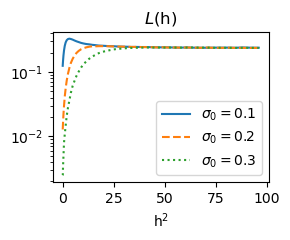

In [8]:
fig = plt.figure(figsize=(3,2.5))
plt.subplot(1,1,1)
for j in range(len(σ0_list)):
    plt.semilogy(h_value**2, intercept_scaling[j,:],\
                 label=r"$\sigma_0 = {:2.1f}$".format(σ0_list[j]), linestyle=linestyle[j])
plt.legend()
plt.xlabel(r'$\mathsf{h}^2$')
plt.title(r'$L(\mathsf{h})$')
plt.tight_layout()
if save_fig:
    plt.savefig("PDF/localized_terminal_leading_term.pdf")
    plt.savefig("EPS/localized_terminal_leading_term.eps")
    plt.savefig("../assets/localized_terminal_leading_term.eps")

### When error is included only at initial period

In [9]:
γ = 0.95
h_N = 50
h_max = 2.0
σ0_list = np.array([0.4, 0.6, 0.8])
intercept_scaling = np.zeros((3, h_N))
default_error_type = t_vec <= γ * T # step function
for j in tqdm(range(len(σ0_list))):
    _, h_value, _, intercept_scaling[j,:], _, _, _, _ = compute_LeadingOrder(σ0_list[j], default_error_type,\
                        save_fig = False, plot_fig = False, h_max=h_max, h_N = h_N)
    L0 = intercept_scaling[j,0]
    Linf = np.mean(intercept_scaling[j,-3:])
    ratio = Linf/L0
    print("L0 = {:.3E}\t\t L_inf = {:.3E}\t\t L_inf/L0 = {:.2E}".format(L0, Linf, ratio))

 33%|███████████████                              | 1/3 [00:05<00:10,  5.25s/it]

Maximum error of coefficient in regression 5.86%
L0 = 2.917E+00		 L_inf = 7.912E-03		 L_inf/L0 = 2.71E-03


 67%|██████████████████████████████               | 2/3 [00:10<00:05,  5.43s/it]

Maximum error of coefficient in regression 4.41%
L0 = 1.987E+00		 L_inf = 4.997E-02		 L_inf/L0 = 2.51E-02


100%|█████████████████████████████████████████████| 3/3 [00:15<00:00,  5.08s/it]

Maximum error of coefficient in regression 3.84%
L0 = 1.376E+00		 L_inf = 1.102E-01		 L_inf/L0 = 8.01E-02


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


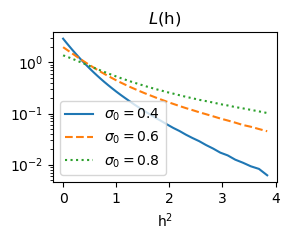

In [10]:
fig = plt.figure(figsize=(3,2.5))
plt.subplot(1,1,1)
for j in range(len(σ0_list)):
    plt.semilogy(h_value**2, intercept_scaling[j,:], \
                 label=r"$\sigma_0 = {:2.1f}$".format(σ0_list[j]), \
                 linestyle=linestyle[j])
plt.legend(loc='lower left')
plt.xlabel(r'$\mathsf{h}^2$')
plt.title(r'$L(\mathsf{h})$')
plt.tight_layout()
if save_fig:
    plt.savefig("PDF/localized_initial_leading_term.pdf")
    plt.savefig("EPS/localized_initial_leading_term.eps")
    plt.savefig("../assets/localized_initial_leading_term.eps")

# Part 4: Estimate $\min_{h} L(h)$ for various $\sigma_0$

 33%|███████████████                              | 1/3 [00:09<00:18,  9.16s/it]

Maximum error of coefficient in regression 4.13%
sigma_0 = 0.2, h at the end = 0.2358


 67%|██████████████████████████████               | 2/3 [00:17<00:08,  8.73s/it]

Maximum error of coefficient in regression 3.00%
sigma_0 = 0.4, h at the end = 0.2360


100%|█████████████████████████████████████████████| 3/3 [00:26<00:00,  8.73s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Maximum error of coefficient in regression 2.37%
sigma_0 = 0.6, h at the end = 0.2371


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


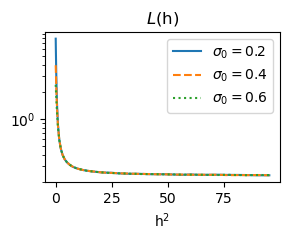

In [11]:
def estimate_L_tail(c=0):
    γ = 1.0
    default_error_type = t_vec <= γ * T
    σ0_list = np.arange(0.2, stop=0.61, step=0.2)

    h_N = 40
    L_value = np.zeros((len(σ0_list),h_N))
    min_intercept_list = np.zeros(len(σ0_list))
    avg_intercept_list = np.zeros(len(σ0_list))
    h_value_vec = []

    for j in tqdm(range(len(σ0_list))):
        _, h_value_vec, _, L_value[j,:], \
            min_intercept_list[j], _, avg_intercept_list[j], _ = compute_LeadingOrder(σ0_list[j], \
                default_error_type, save_fig=False, plot_fig=False, h_max = 10.0, h_N = h_N)
        print("sigma_0 = {:2.1f}, h at the end = {:.4f}".format(σ0_list[j], L_value[j,-1]))
    
    plt.figure(figsize=(3,2.5))
    plt.subplot(1,1,1)
    for j in range(len(σ0_list)):
        idx = h_value_vec >= c
        plt.semilogy(h_value_vec[idx]**2, L_value[j,idx], linestyle=linestyle[np.mod(j,4)], \
                 label = r"$\sigma_0 = {:2.1f}$".format(σ0_list[j]))
    plt.legend()
    plt.xlabel(r"$\mathsf{h}^2$")
    plt.title(r'$L(\mathsf{h})$')
    plt.tight_layout()
    plt.savefig("EPS/Leading_Limit.eps")
    plt.savefig("PDF/Leading_Limit.pdf")
    plt.savefig("../assets/Leading_Limit.eps")

estimate_L_tail()

# Part 5 Estimate $L$ as a function of $h$, $\sigma_0$ and $\mathscr{E}$

In [12]:
def estimate_L_as_a_function():
    
    h_max = np.sqrt(20)
    h_N = 40
    αscale_cases = [1, -1, 1/2*(1+torch.sin(2*np.pi*t_vec/T))]
    σ0_cases = [0.2, 0.4, 0.6, 0.8, 1.5, 2.0, 3.0]

    fig = plt.figure(figsize=(8,10))
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.4)

    intercept_min_table = np.zeros((len(σ0_cases), len(αscale_cases)))
    intercept_avg_table = np.zeros((len(σ0_cases), len(αscale_cases)))

    for i in range(len(σ0_cases)):
        for k in range(len(αscale_cases)):
            print((i,k))

            h_value = []
            σ0 = σ0_cases[i]
            error_type = αscale_cases[k]
            _, h_value, _, L_value, intercept_min, _, intercept_avg, _ = \
                compute_LeadingOrder(σ0, error_type, plot_fig=False, \
                    h_max = h_max, h_N = h_N, est_num = 2)

            ax = plt.subplot(len(σ0_cases),len(αscale_cases), i*len(αscale_cases)+k+1)
            ax.yaxis.set_major_locator(MaxNLocator(3)) 
            ax.plot(h_value.numpy()**2, np.log10(L_value))

            intercept_min_table[i,k] = intercept_min
            intercept_avg_table[i,k] = intercept_avg

            if k == 0:
                ax.set_ylabel(r"$\sigma_0 = {0}$".format(σ0))
            if i == 0:
                ax.set_title(r"case {0}".format(k+1))
    #         s = "{:d}{:d}".format(i,k)
    #         plt.title(s)

    if save_fig:
        plt.savefig("PDF/L_wrt_const_h.pdf")
        plt.savefig("EPS/L_wrt_const_h.eps")
        plt.savefig("../assets/L_wrt_const_h.eps")
        
    df_min = pd.DataFrame(intercept_min_table, columns = ['case 1', 'case 2', 'case 3'], index = σ0_cases)
    df_avg = pd.DataFrame(intercept_avg_table, columns = ['case 1', 'case 2', 'case 3'], index = σ0_cases)
    return intercept_min_table, intercept_avg_table, df_min, df_avg

(0, 0)
Maximum error of coefficient in regression 4.13%
(0, 1)
Maximum error of coefficient in regression 3.94%
(0, 2)
Maximum error of coefficient in regression 1.63%
(1, 0)
Maximum error of coefficient in regression 3.00%
(1, 1)
Maximum error of coefficient in regression 2.89%
(1, 2)
Maximum error of coefficient in regression 1.23%
(2, 0)
Maximum error of coefficient in regression 2.37%
(2, 1)
Maximum error of coefficient in regression 2.38%
(2, 2)
Maximum error of coefficient in regression 1.40%
(3, 0)
Maximum error of coefficient in regression 2.08%
(3, 1)
Maximum error of coefficient in regression 2.29%
(3, 2)
Maximum error of coefficient in regression 1.69%
(4, 0)
Maximum error of coefficient in regression 1.87%
(4, 1)
Maximum error of coefficient in regression 1.93%
(4, 2)
Maximum error of coefficient in regression 2.39%
(5, 0)
Maximum error of coefficient in regression 1.76%
(5, 1)
Maximum error of coefficient in regression 1.84%
(5, 2)
Maximum error of coefficient in regressio

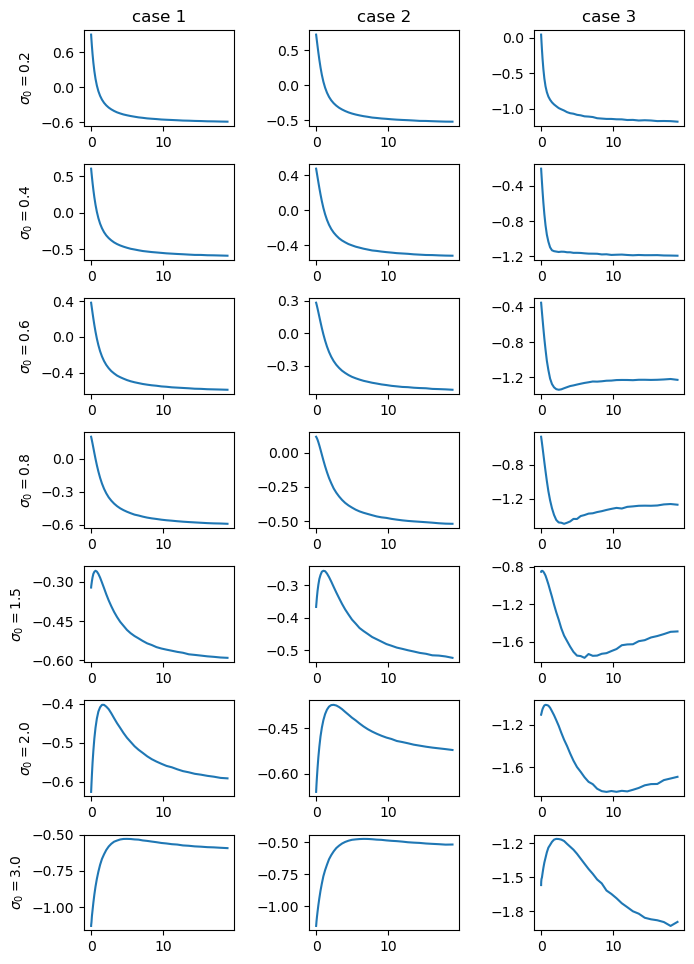

In [13]:
trunc = lambda x: math.trunc(10000 * x) / 10000;
_, _, df_min, df_avg =  estimate_L_as_a_function()

In [14]:
df_min.applymap(trunc)

,case 1,case 2,case 3
0.2,0.2561,0.3030,0.0652
0.4,0.2561,0.3023,0.0635
0.6,0.2563,0.3005,0.0455
0.8,0.2562,0.3019,0.0322
1.5,0.2566,0.3002,0.0169
2.0,0.2364,0.2191,0.0145
3.0,0.0739,0.0706,0.0116


In [15]:
df_avg.applymap(trunc)

,case 1,case 2,case 3
0.2,0.2567,0.3032,0.0658
0.4,0.2569,0.3028,0.0636
0.6,0.2570,0.3018,0.0597
0.8,0.2569,0.3023,0.0544
1.5,0.2570,0.3017,0.0321
2.0,0.2564,0.3022,0.0198
3.0,0.2566,0.3020,0.0121
